In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

### Code to generate 3D dataset lying close to a 2D subspace

In [27]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [28]:
from mpl_toolkits.mplot3d import Axes3D

# Dimensionality Reduction

In [96]:
# a simple 3D dataset

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

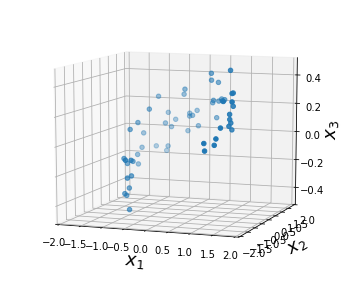

In [99]:
# draw the data 
axes = [-2, 2, -2, 2, -0.5, 0.5]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In [6]:
# following code is using SVD to find the PC
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0] # first PC
c2 = Vt.T[:, 1] # second PC

In [8]:
# projecting the 3d data set into 2d
W2 = Vt.T[:, :2]
X2D = X_centered @ W2

In [10]:
# following code execute above PCA by SKLearn
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [12]:
pca.components_ # tranpose of the unit vector of PC

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [13]:
c1, c2

(array([0.93636116, 0.29854881, 0.18465208]),
 array([-0.34027485,  0.90119108,  0.2684542 ]))

In [14]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

## Choosing the Right Number of Dimensions

In [15]:
# prepare the data
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

from sklearn.model_selection import train_test_split
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
# the code to get the number of dimensions required to preserve 95% of variance of MNIST-784
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [20]:
# or directly tell the PCA the ratio you want to preserve!
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [21]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557437

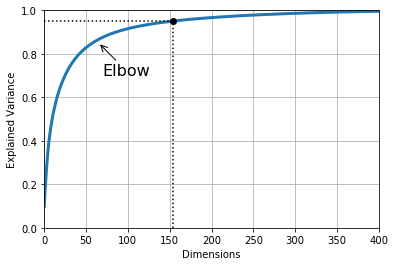

In [18]:
# using plot to decide what is the PC number you want to preserve!
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

## PCA for Compression 

In [22]:
# following code compress and decompress the MNIST dataset
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

## Randomized PCA

In [23]:
# application of Randomized PCA which saves time by approximation
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA

In [24]:
# application of Incremental PCA to split training set
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

## Kernel PCA
Let's Generate a Swiss Roll to test how different Kernels do their jobs

In [102]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

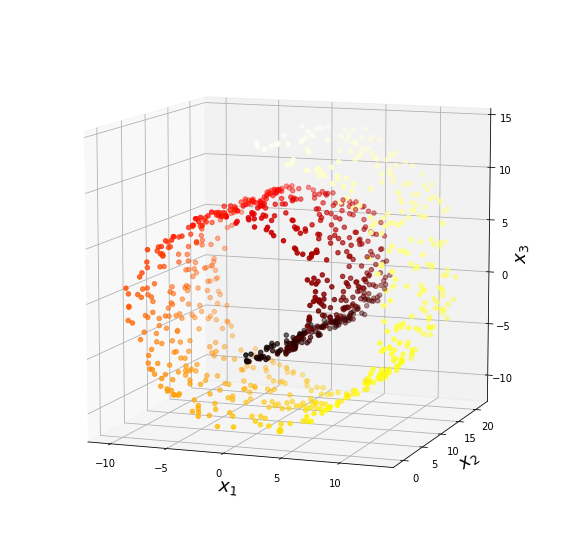

In [39]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In [40]:
from sklearn.decomposition import KernelPCA

### Linear Kernel

In [53]:
# application on using Linear Kernel on a Swiss Roll Data
lin_pca = KernelPCA(n_components = 2, kernel="linear", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

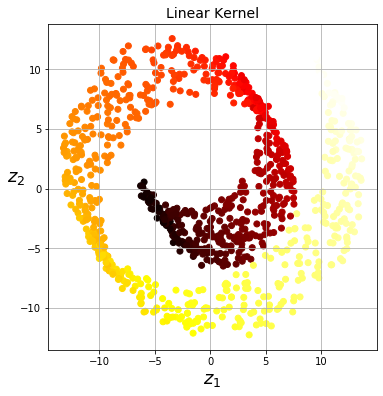

In [54]:
# visulize it in 2D space
y = t > 6.9
plt.figure(figsize=(20, 6))

pca = lin_pca
title = "Linear Kernel"

X_reduced = pca.fit_transform(X)

plt.subplot(subplot)
plt.title(title, fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

### RBF Kernel

In [57]:
# application on using RBF Kernel on a Swiss Roll Data
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)

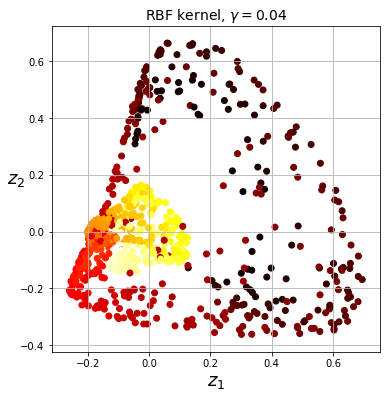

In [63]:
# visulize it in 2D space
y = t > 6.9
plt.figure(figsize=(20, 6))

pca = rbf_pca
title = "RBF Kernel, $\gamma=0.04$"

X_reduced = pca.fit_transform(X)
X_reduced_rbf = X_reduced

plt.subplot(subplot)
plt.title(title, fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

### Sigmoid Kernel

In [59]:
# application on using Linear Kernel on a Swiss Roll Data
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)

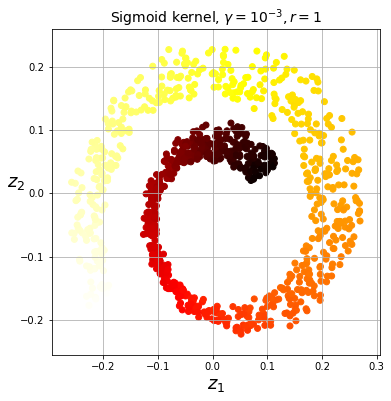

In [62]:
# visulize it in 2D space
y = t > 6.9
plt.figure(figsize=(20, 6))

pca = sig_pca
title = "Sigmoid Kernel, $\gamma=10^{-3}, r=1$"

X_reduced = pca.fit_transform(X)

plt.subplot(subplot)
plt.title(title, fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

### Polynomial Kernel

In [72]:
# application on using Linear Kernel on a Swiss Roll Data
poly_pca = KernelPCA(n_components = 2, kernel="poly", gamma=0.01, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)

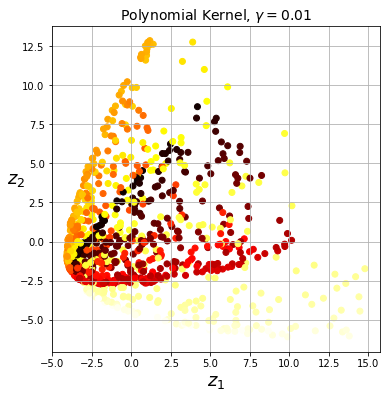

In [74]:
# visulize it in 2D space
y = t > 6.9
plt.figure(figsize=(20, 6))

pca = poly_pca
title = "Polynomial Kernel, $\gamma=0.01$"

X_reduced = pca.fit_transform(X)

plt.subplot(subplot)
plt.title(title, fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

### Cosine Kernel

In [81]:
# application on using Linear Kernel on a Swiss Roll Data
cos_pca = KernelPCA(n_components = 2, kernel="cosine", gamma=0.01, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)

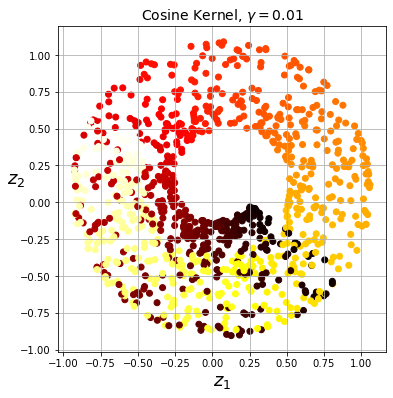

In [82]:
# visulize it in 2D space
y = t > 6.9
plt.figure(figsize=(20, 6))

pca = cos_pca
title = "Cosine Kernel, $\gamma=0.01$"

X_reduced = pca.fit_transform(X)

plt.subplot(subplot)
plt.title(title, fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

## Selecting a Kernel and Tuning Hyperparameters

In [86]:
# By using Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [87]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [88]:
# By using Lowest Reconstruction pre-image error

# get the pre-image 
rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.0433,
                   fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced) # this method only exist when fit_inverse_transform is setted as true

# get the reconstruction error
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

32.78630879576617

# LLE

In [92]:
# an application of LLE to unroll the Swiss roll
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

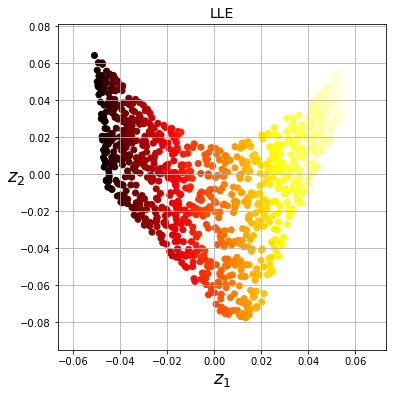

In [93]:
# visulize it in 2D space
y = t > 6.9
plt.figure(figsize=(20, 6))

title = "LLE"

plt.subplot(subplot)
plt.title(title, fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

# Other Techniques
## MDS (Multimensional Scaling)

In [103]:
# application of mds on swiss roll
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

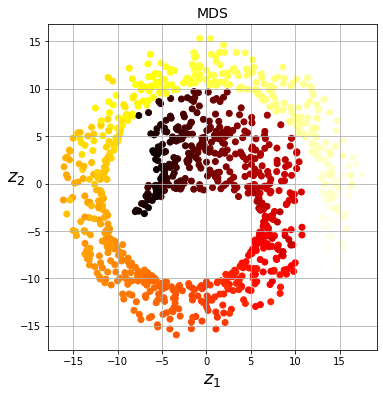

In [104]:
# visulize it in 2D space
y = t > 6.9
plt.figure(figsize=(20, 6))

title = "MDS"

plt.subplot(subplot)
plt.title(title, fontsize=14)
plt.scatter(X_reduced_mds[:, 0], X_reduced_mds[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

## Isomap

In [105]:
# application of Isomap on Swiss Roll
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

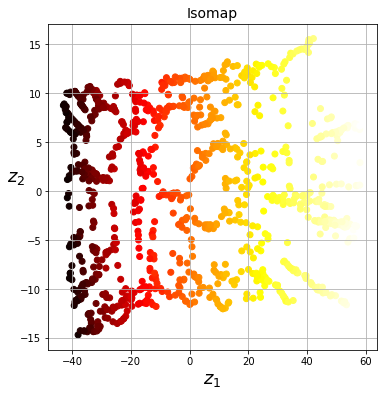

In [106]:
# visulize it in 2D space
y = t > 6.9
plt.figure(figsize=(20, 6))

title = "Isomap"

plt.subplot(subplot)
plt.title(title, fontsize=14)
plt.scatter(X_reduced_isomap[:, 0], X_reduced_isomap[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

## t-SNE

In [108]:
# application of t-SNE on Swiss Roll
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

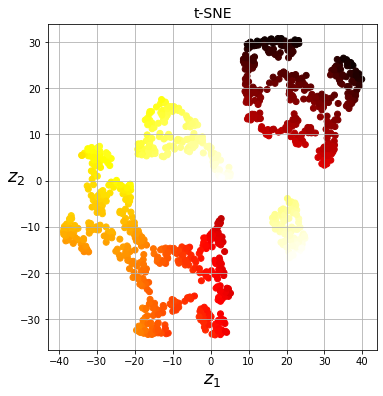

In [109]:
# visulize it in 2D space
y = t > 6.9
plt.figure(figsize=(20, 6))

title = "t-SNE"

plt.subplot(subplot)
plt.title(title, fontsize=14)
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()